In [1]:
import os

import pandas as pd
import numpy as np

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns
### sns.set_style('darkgrid')

# scikit-learn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

# Function for creating model pipelines - sklearn
from sklearn.pipeline import make_pipeline

# Function for creating model pipelines - imblearn
from imblearn.pipeline import make_pipeline as imbl_pipe

# Over-sampling using SMOTE
from imblearn.over_sampling import SMOTE


## Load Analytical Base Table

In [2]:
abt = pd.read_csv("../Resources/Analytical_Base_Table.csv")
abt.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,30.5,33.6,0.627000,50.0,1
1,1.0,85.0,66.0,29.0,30.5,26.6,0.351000,31.0,0
2,8.0,183.0,64.0,23.0,30.5,23.3,0.672000,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167000,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,0.471876,33.0,1


### Separate dataframe into separate object

In [3]:
X = abt.drop(["class"], axis=1)

y = abt["class"]

# display shapes of X and y
print(X.shape, y.shape)

(768, 8) (768,)


In [4]:
# List numerical features
num_columns = X.select_dtypes(include='number').columns.tolist()
num_columns

['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age']

In [5]:
# List categorical features
cat_columns = X.select_dtypes(include='object').columns.tolist()
cat_columns

[]

In [6]:
# distribution of churn
col1 = y.value_counts()
col2 = y.value_counts(normalize=True)*100
pd.DataFrame(data={'Target':[0,1],'Diabetic':col1,'Diabetic %':col2.round(2)})

,Target,Diabetic,Diabetic %
0,0,500,65.1
1,1,268,34.9


## Create a Train Test Split

In [7]:
random_state = 10

# Split X and y into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=random_state)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

537 231 537 231


In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537 entries, 491 to 265
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    537 non-null    float64
 1   plas    537 non-null    float64
 2   pres    537 non-null    float64
 3   skin    537 non-null    float64
 4   test    537 non-null    float64
 5   mass    537 non-null    float64
 6   pedi    537 non-null    float64
 7   age     537 non-null    float64
dtypes: float64(8)
memory usage: 37.8 KB


## Pre-processing Pipeline

### Scale numerical data and encode categorical data
Construct a pre-processing pipeline from the given transformers: MinMaxScaler and OneHotEncoder

Create lists of indexes from the list of column names

Need to be numeric not string to specify columns name in column transformer

In [9]:
num_features = [] 

for i in num_columns:
    location = X.columns.get_loc(i)
    num_features.append(location)
print(num_features)  

[0, 1, 2, 3, 4, 5, 6, 7]


In [10]:
cat_features = []

for i in cat_columns:
    location = X.columns.get_loc(i)
    cat_features.append(location)
print(cat_features)  

[]


In [11]:
# Define column transformer
# Need to be numeric not string to specify columns name 
preprocess = make_column_transformer(
    (MinMaxScaler(), num_features),
    (OneHotEncoder(sparse=False), cat_features)
)
preprocess

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 [0, 1, 2, 3, 4, 5, 6, 7]),
                                ('onehotencoder', OneHotEncoder(sparse=False),
                                 [])])

## Build Model Pipeline with SMOTE

* We are going to use the Pipeline from the imblearn package in place of scikit-learn Pipeline.

* It takes care automatically to re-sample when called fit() on the pipeline, and does not re-sample test data (when called transform() or predict()).

In [12]:
# Import classifier
from sklearn.svm import SVC 

# Define model with pipeline
model = imbl_pipe(preprocess,
                  SMOTE(sampling_strategy='auto', random_state=random_state),
                  SVC(random_state=random_state))

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  [0, 1, 2, 3, 4, 5, 6, 7]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  [])])),
                ('smote', SMOTE(random_state=10)),
                ('svc', SVC(random_state=10))])

In [13]:
# Create the GridSearchCV model
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV

param_grid = {'svc__kernel' : ['linear', 'rbf', 'poly', 'sigmoid'],
              'svc__C': [0.0005,0.001, 0.01, 0.1, 0.5],
              'svc__gamma': [5, 1, 0.1, 0.01]}
grid = GridSearchCV(model, param_grid, verbose=3, cv= 5, n_jobs=4, scoring='accuracy')

In [14]:
# Train the model with GridSearch
grid.fit(X_train, y_train)


Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6,
                                                                          7]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(sparse=False),
                                                                         [])])),
                                       ('smote', SMOTE(random_state=10)),
                                       ('svc', SVC(random_state=10))]),
             n_jobs=4,
             param_grid={'svc__C': [0.0005, 0.001, 0.01, 0.1, 0.5],
                         'svc__gamma': [5, 1, 0.1, 0.01],
                         'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy', verbose=3)

In [15]:
print(grid.best_params_)

{'svc__C': 0.1, 'svc__gamma': 5, 'svc__kernel': 'poly'}


In [16]:
 # List the best score
print(grid.best_score_)

0.767203184492904


In [17]:
print(f"Training Data Score: {grid.score(X_train, y_train)}")
print(f"Testing Data Score: {grid.score(X_test, y_test)}")

Training Data Score: 0.8286778398510242
Testing Data Score: 0.7316017316017316


In [18]:
# Make predictions with the hypertuned model
predictions = grid.predict(X_test)
predictions

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0], dtype=int64)

In [19]:
# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, predictions)
print(cm)

[[120  24]
 [ 38  49]]


In [20]:
cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
print(cm)

[[0.83 0.17]
 [0.44 0.56]]


In [21]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.76      0.83      0.79       144
           1       0.67      0.56      0.61        87

    accuracy                           0.73       231
   macro avg       0.72      0.70      0.70       231
weighted avg       0.73      0.73      0.73       231



In [22]:
predictions

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0], dtype=int64)

In [23]:
pred = grid.predict(X_test[:1])

In [24]:
print(f"Predicted classes: {pred}")
print(f"Actual Labels: {list(y_test[:1])}")

Predicted classes: [1]
Actual Labels: [0]


C:\Users\pavanksu2009\AppData\Local\Temp\ipykernel_9108\3302990698.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(f"Actual Labels: {list(y_test[:1])}")


## Save the Model

In [27]:
import joblib

# We are saving our grid model
filename = '../models/challa_SVM_model.sav'
joblib.dump(grid, filename)

['../models/challa_SVM_model.sav']

## Loading the Model

In [28]:
# load the model
svm_model = joblib.load(filename)
print(svm_model.score(X_test, y_test))

0.7316017316017316


### Predict class for new data

In [29]:
# Let's use the first X_test record as new data
X_test[:1]

,preg,plas,pres,skin,test,mass,pedi,age
568,4.0,154.0,72.0,29.0,126.0,31.3,0.338,37.0


In [30]:
pred_new = grid.predict(X_test[:1])

In [31]:
print(f"Predicted classes: {pred_new}")
print(f"Actual Labels: {list(y_test[:1])}")

Predicted classes: [1]
Actual Labels: [0]


C:\Users\pavanksu2009\AppData\Local\Temp\ipykernel_9108\3231625543.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(f"Actual Labels: {list(y_test[:1])}")


#### Original dataframe to numpy array

In [32]:
X_test[:1].to_numpy()

array([[  4.   , 154.   ,  72.   ,  29.   , 126.   ,  31.3  ,   0.338,
         37.   ]])

In [33]:
pred_new1 = grid.predict(X_test[:1].to_numpy())
pred_new1

c:\Users\pavanksu2009\.virtualenvs\Diabetes-Classification-Ri9St7y4\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([1], dtype=int64)

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [35]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [36]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [37]:
LR_perf_train = model_performance_classification_sklearn(grid, X_train, y_train)
LR_perf_train

,Accuracy,Recall,Precision,F1
0,0.828678,0.734807,0.751412,0.743017


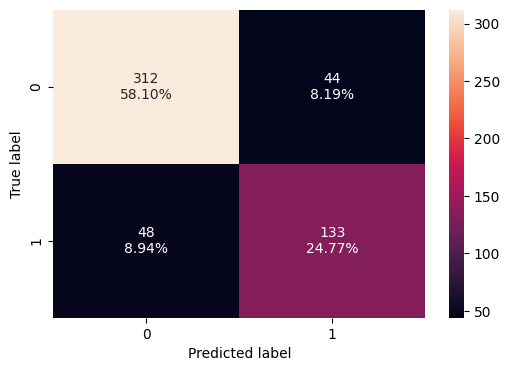

In [39]:
confusion_matrix_sklearn(grid, X_train, y_train)

In [40]:
LR_perf_test = model_performance_classification_sklearn(grid, X_test, y_test)
LR_perf_test

,Accuracy,Recall,Precision,F1
0,0.731602,0.563218,0.671233,0.6125


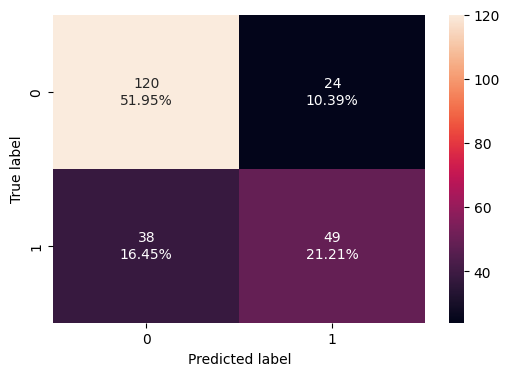

In [41]:
confusion_matrix_sklearn(grid, X_test, y_test)

In [42]:
df1 = pd.DataFrame(model_performance_classification_sklearn(grid, X_test, y_test).T).reset_index().rename(columns={'index':'Metrics_names',0:'Testing_Metrics'})
df1

,Metrics_names,Testing_Metrics
0,Accuracy,0.731602
1,Recall,0.563218
2,Precision,0.671233
3,F1,0.612500


In [43]:
df2 = pd.DataFrame(model_performance_classification_sklearn(grid, X_train, y_train).T).reset_index().rename(columns={'index':'Metrics_names',0:'Training_Metrics'})
df2

,Metrics_names,Training_Metrics
0,Accuracy,0.828678
1,Recall,0.734807
2,Precision,0.751412
3,F1,0.743017


In [44]:
Output_df = pd.merge(df2, df1, on='Metrics_names')
display(Output_df)

,Metrics_names,Training_Metrics,Testing_Metrics
0,Accuracy,0.828678,0.731602
1,Recall,0.734807,0.563218
2,Precision,0.751412,0.671233
3,F1,0.743017,0.612500
